# This is an intro to Document clustering made by refering to 

https://github.com/brandomr/document_cluster

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [2]:
with open("./data/title_list.txt") as file:
    titles = [line.strip() for line in file]

In [3]:
synopses = []

In [4]:
with open("./data/synopses_list_wiki.txt") as file:
    i = True
    l = ' '
    for line in file:            
        if 'BREAKS HERE Plot' in line:
            synopses.append(l) # append the previously collected lines
            l = ' '
        
        l = l + line.strip()

In [7]:
synopses.append('') # run this 3 times

In [8]:
len(synopses)

100

# Stopwords, stemming, and tokenizing¶

In [9]:
stopwords = nltk.corpus.stopwords.words('english')

In [10]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [11]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [12]:
#  iterate over the list of synopses to create two vocabularies

totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [13]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 162054 items in vocab_frame


In [14]:
print(vocab_frame.head())

     words
plot  plot
edit  edit
edit  edit
edit  edit
on      on


# Tf-idf and document similarity

![title](./images/tf_idf.png)

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 8.55 s, sys: 16 ms, total: 8.56 s
Wall time: 8.63 s
(100, 212)


Vocabulary

In [16]:
terms = tfidf_vectorizer.get_feature_names()

In [17]:
terms

['accept',
 'agre',
 'allow',
 'alon',
 'american',
 'ani',
 'anoth',
 'apart',
 'appear',
 'approach',
 'arm',
 'armi',
 'arrang',
 'arriv',
 'ask',
 'attack',
 'attempt',
 'away',
 'becaus',
 'becom',
 'befor',
 'begin',
 'believ',
 'bodi',
 'bring',
 'car',
 'carri',
 'caus',
 'chang',
 'charg',
 'children',
 'citi',
 'claim',
 'close',
 'come',
 'command',
 'commit',
 'confess',
 'confront',
 'continu',
 'convinc',
 'daughter',
 'day',
 'dead',
 'death',
 'decid',
 'despit',
 'did',
 'die',
 'discov',
 'discuss',
 'doe',
 'drive',
 'dure',
 'encount',
 'end',
 'enter',
 'escap',
 'eventu',
 'explain',
 'face',
 'fail',
 'fall',
 'famili',
 'father',
 'feel',
 'fight',
 'film',
 'final',
 'flee',
 'follow',
 'forc',
 'friend',
 'girl',
 'goe',
 'gun',
 'hand',
 'happen',
 'head',
 'hear',
 'help',
 'hide',
 'hold',
 'home',
 'hope',
 'hous',
 'howev',
 'immedi',
 'includ',
 'inform',
 'initi',
 'insist',
 'instead',
 'invit',
 'job',
 'john',
 'join',
 'just',
 'kill',
 'know',
 'la

Calculate the cosine similarity using the tf_idf matrix
![title](./images/cosine.png)

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# K-Means Clustering

In [19]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 356 ms, sys: 4 ms, total: 360 ms
Wall time: 526 ms


In [20]:
from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [21]:
with open("./data/genres_list.txt") as file:
    genres = [line.strip() for line in file]

In [22]:
# Couldn't scrap ranks from IMDB
# Therefore, im creating random ranks
import random
ranks = []

for num in range(100):
    ranks.extend(random.sample(range(1, 10), 1))

In [23]:
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

In [24]:
len(clusters)

100

In [25]:
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [26]:
frame['cluster'].value_counts()

3    27
4    25
1    24
0    17
2     7
Name: cluster, dtype: int64

In [27]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b'family', b'father', b'son', b'killed', b'friends', b'murders',

Cluster 0 titles: The Godfather, The Godfather: Part II, On the Waterfront,

/home/dhantha/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
/home/dhantha/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


 The Sound of Music, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, The Lord of the Rings: The Return of the King, My Fair Lady, Jaws, The Pianist, City Lights, It Happened One Night, Fargo, Giant, Double Indemnity, The Third Man, North by Northwest, Yankee Doodle Dandy,

Cluster 1 words: b'car', b'killed', b'police', b'arrive', b'tells', b'drives',

Cluster 1 titles: The Shawshank Redemption, Titanic, Sunset Blvd., Vertigo, West Side Story, 2001: A Space Odyssey, The Silence of the Lambs, Chinatown, Unforgiven, The Good, the Bad and the Ugly, Butch Cassidy and the Sundance Kid, All Quiet on the Western Front, The King's Speech, Mr. Smith Goes to Washington, Tootsie, The Green Mile, Network, Nashville, The Graduate, American Graffiti, Mutiny on the Bounty, A Clockwork Orange, Wuthering Heights, Rear Window,

Cluster 2 words: b'apartment', b'police', b'officers', b'woman', b'murders', b'leave',

Cluster 2 titles: Casablanca, Psycho, Rocky, The Treasure of the Sier

# Multidimensional Scaling

In [28]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()


In [29]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

/home/dhantha/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


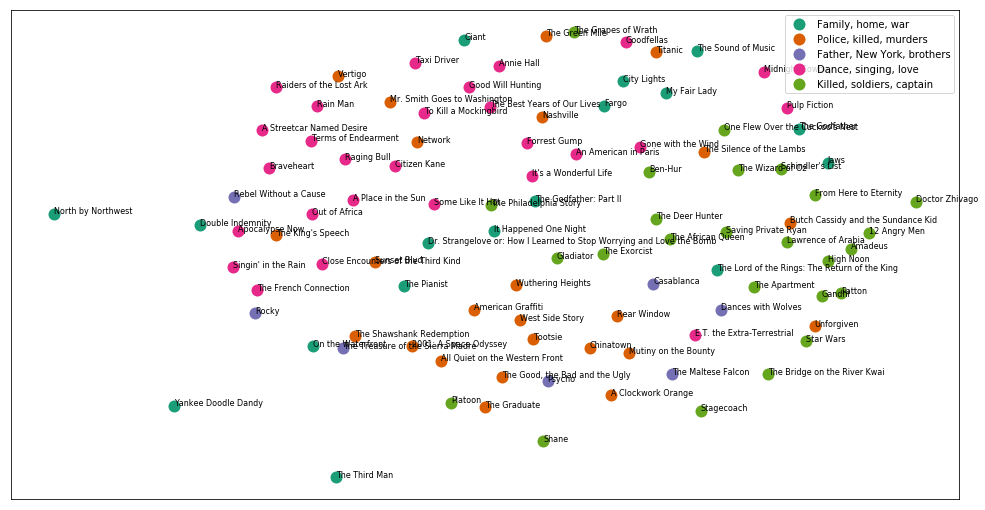

In [30]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

3#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [31]:
plt.close()

# Hierarchical document clustering

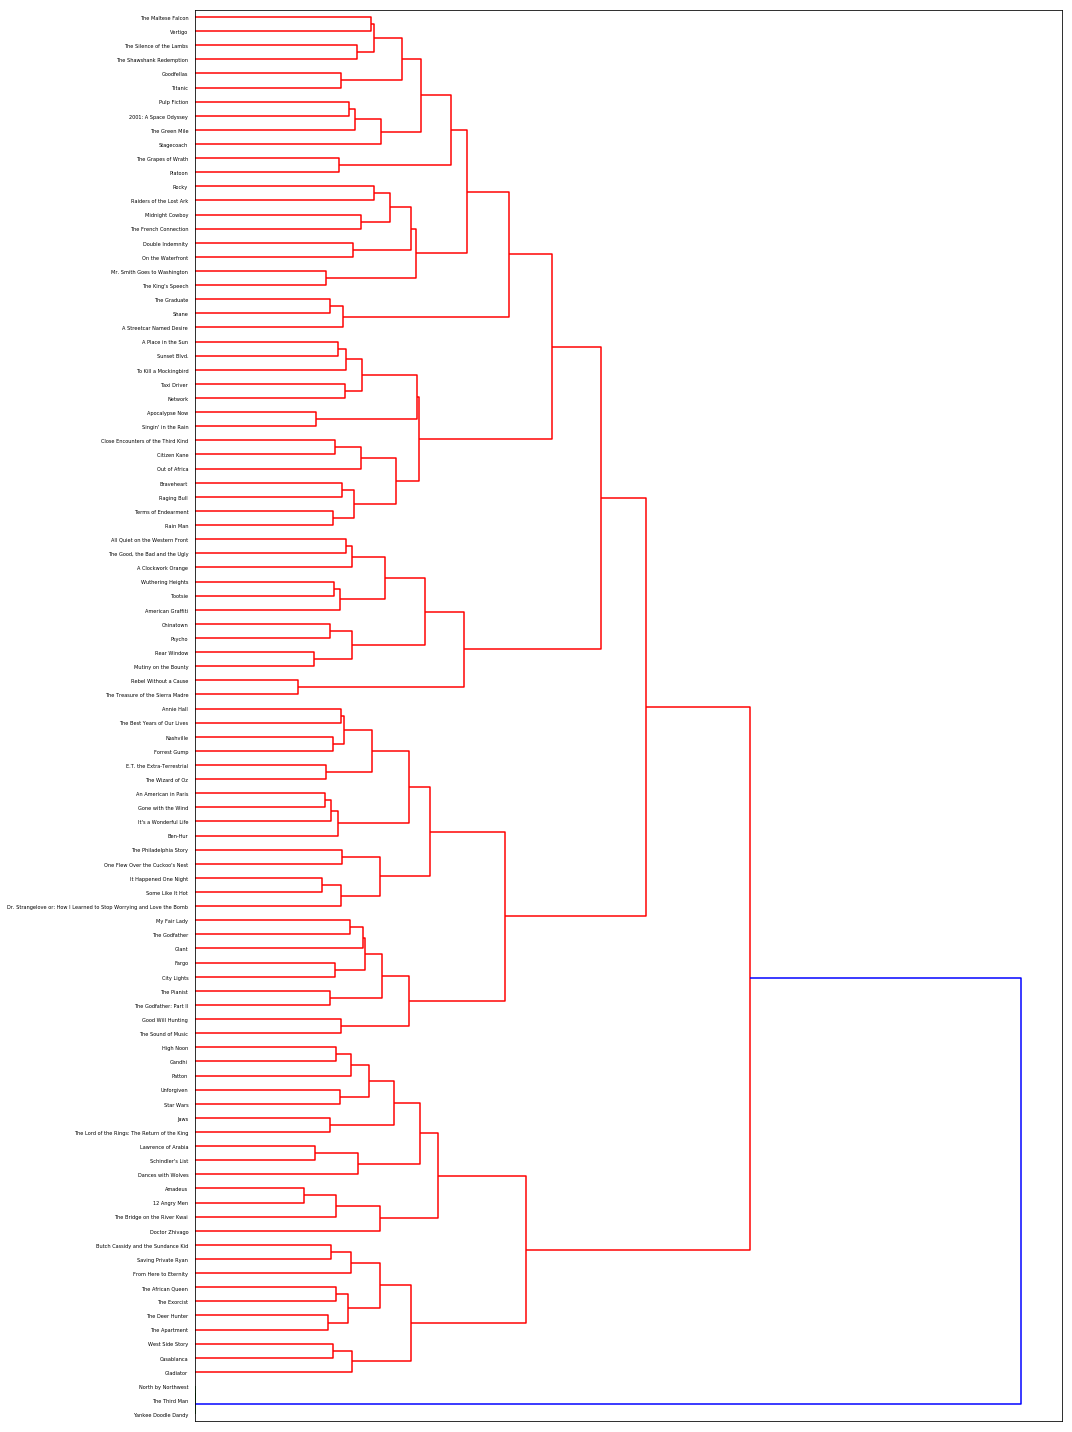

In [32]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

# Latent Dirichlet Allocation (LDA)

LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics.

In [33]:
#strip any proper names from a text
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [34]:
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns


In [35]:
from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in synopses]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

Using Theano backend.


CPU times: user 3.92 s, sys: 8 ms, total: 3.93 s
Wall time: 3.93 s
CPU times: user 4.57 s, sys: 24 ms, total: 4.59 s
Wall time: 4.59 s
CPU times: user 476 ms, sys: 4 ms, total: 480 ms
Wall time: 479 ms


In [36]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [42]:
%time lda = models.LdaModel(corpus,num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 15min 53s, sys: 15.9 s, total: 16min 9s
Wall time: 8min 15s


In [43]:
lda.show_topics()

[(0,
  '0.006*"find" + 0.006*"kill" + 0.006*"return" + 0.004*"tell" + 0.004*"leav" + 0.004*"take" + 0.004*"day" + 0.004*"agre" + 0.004*"meet" + 0.004*"home"'),
 (1,
  '0.006*"leav" + 0.006*"kill" + 0.005*"find" + 0.005*"return" + 0.005*"tell" + 0.005*"take" + 0.004*"friend" + 0.004*"ask" + 0.004*"apart" + 0.004*"back"'),
 (2,
  '0.006*"kill" + 0.005*"order" + 0.004*"make" + 0.004*"take" + 0.004*"leav" + 0.004*"famili" + 0.004*"man" + 0.004*"befor" + 0.004*"home" + 0.004*"back"'),
 (3,
  '0.007*"kill" + 0.006*"take" + 0.006*"arriv" + 0.006*"leav" + 0.005*"tell" + 0.005*"man" + 0.005*"return" + 0.005*"find" + 0.004*"shark" + 0.004*"shoot"'),
 (4,
  '0.005*"tell" + 0.004*"return" + 0.004*"kill" + 0.004*"tri" + 0.004*"take" + 0.004*"make" + 0.004*"friend" + 0.004*"end" + 0.004*"home" + 0.004*"first"')]

In [54]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

In [61]:
type(topics_matrix)

list

In [57]:
#topic_words = topics_matrix[:,:,1]
for i in topics_matrix:
    print([str(word) for word in i])
    print()

['0', "[('find', 0.0064745642115583311), ('kill', 0.0057577382007760183), ('return', 0.0056383357749752927), ('tell', 0.0043242664508733519), ('leav', 0.0043242634222007527), ('take', 0.0043242611524814756), ('day', 0.0040854398921010369), ('agre', 0.0038465666552611462), ('meet', 0.0038465036908803939), ('home', 0.0038464742466686984), ('die', 0.003607582526771316), ('tribe', 0.0034880424521175992), ('attempt', 0.0033686940129263251), ('make', 0.0033686175281822817), ('call', 0.0032492231326638572), ('begin', 0.0031297566624540565), ('onli', 0.0031297249436597029), ('offic', 0.0030103332185612529), ('decid', 0.0028908428733594358), ('give', 0.0028908237292961693)]"]

['1', "[('leav', 0.0061650072368445883), ('kill', 0.0055497252199657073), ('find', 0.0050693549875907417), ('return', 0.0049729778542430391), ('tell', 0.0048774387107796205), ('take', 0.0048265139944202728), ('friend', 0.0044466403420641704), ('ask', 0.0044000664949433782), ('apart', 0.0042542892888137694), ('back', 0.004

In [ ]:
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,:,1]